In [1]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### DEFINE SOME PARAMETERS ###

base_path = "data/"
SHAPE = (224, 224, 3)
batch_size = 5

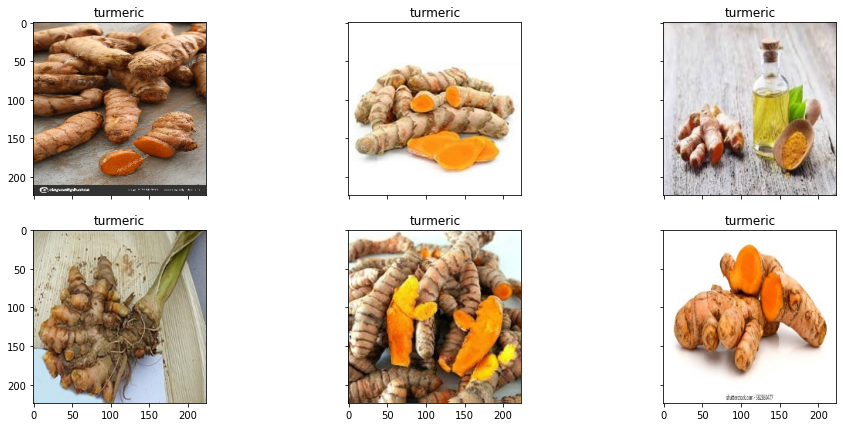

In [4]:
### PLOT SAMPLE IMAGES ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax in axes.ravel():
    label = np.random.choice(os.listdir(base_path + "train"))
    img = np.random.choice(os.listdir(base_path + "train/" + label))
    img = cv2.imread(base_path + "train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [5]:
### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        
        yield x,y

In [6]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(train=True):
    
    set_seed(33)
    
    pre_process = Lambda(preprocess_input)
    vgg = VGG16(weights = 'imagenet', include_top = True, input_shape = SHAPE)
    vgg = Model(vgg.input, vgg.layers[-3].output)
    vgg.trainable = False
    
    inp = Input(SHAPE)
    vgg_16_process = pre_process(GaussianNoise(0.1)(inp))
    vgg_out = vgg(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out
        
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(Adam(lr=1e-4), loss='binary_crossentropy')
    
    return model

In [7]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [8]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path + 'train/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['turmeric']
    )

test_generator = test_datagen.flow_from_directory(
            base_path + 'test/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['chilli', 'turmeric']
)

Found 50 images belonging to 1 classes.
Found 40 images belonging to 2 classes.


In [9]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=10)

c:\users\kmgs4\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.0285
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.3250
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.2639
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 0.2232
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.1486
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.1069
Epoch 7/10
10/10 [==============================] - 13s 1s/step - loss: 0.0767
Epoch 8/10
10/10 [==============================] - 13s 1s/step - loss: 0.0561
Epoch 9/10
10/10 [==============================] - 13s 1s/step - loss: 0.0425
Epoch 10/10
10/10 [==============================] - 13s 1s/step - loss: 0.0320


In [10]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(40,)

In [ ]:
model.get_weights()

In [11]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
ineference_model.set_weights(model.get_weights())

In [12]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [13]:
### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.975


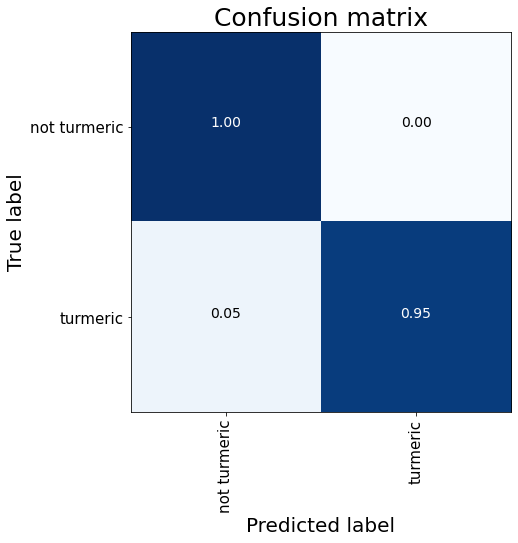

In [14]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['not turmeric','turmeric'])
plt.show()